In [ ]:
suppressMessages(library("basedosdados"))
library("ggplot2")
suppressWarnings(library("dplyr"))
library("geobr")
library("sf")
set_billing_id("processo-seletivo-luiz")
#importando os dados do datalake
df_resultado <- 
  suppressWarnings(read_sql(query = 'SELECT * FROM `basedosdados.br_tse_eleicoes.resultados_candidato` LIMIT 3000000'))

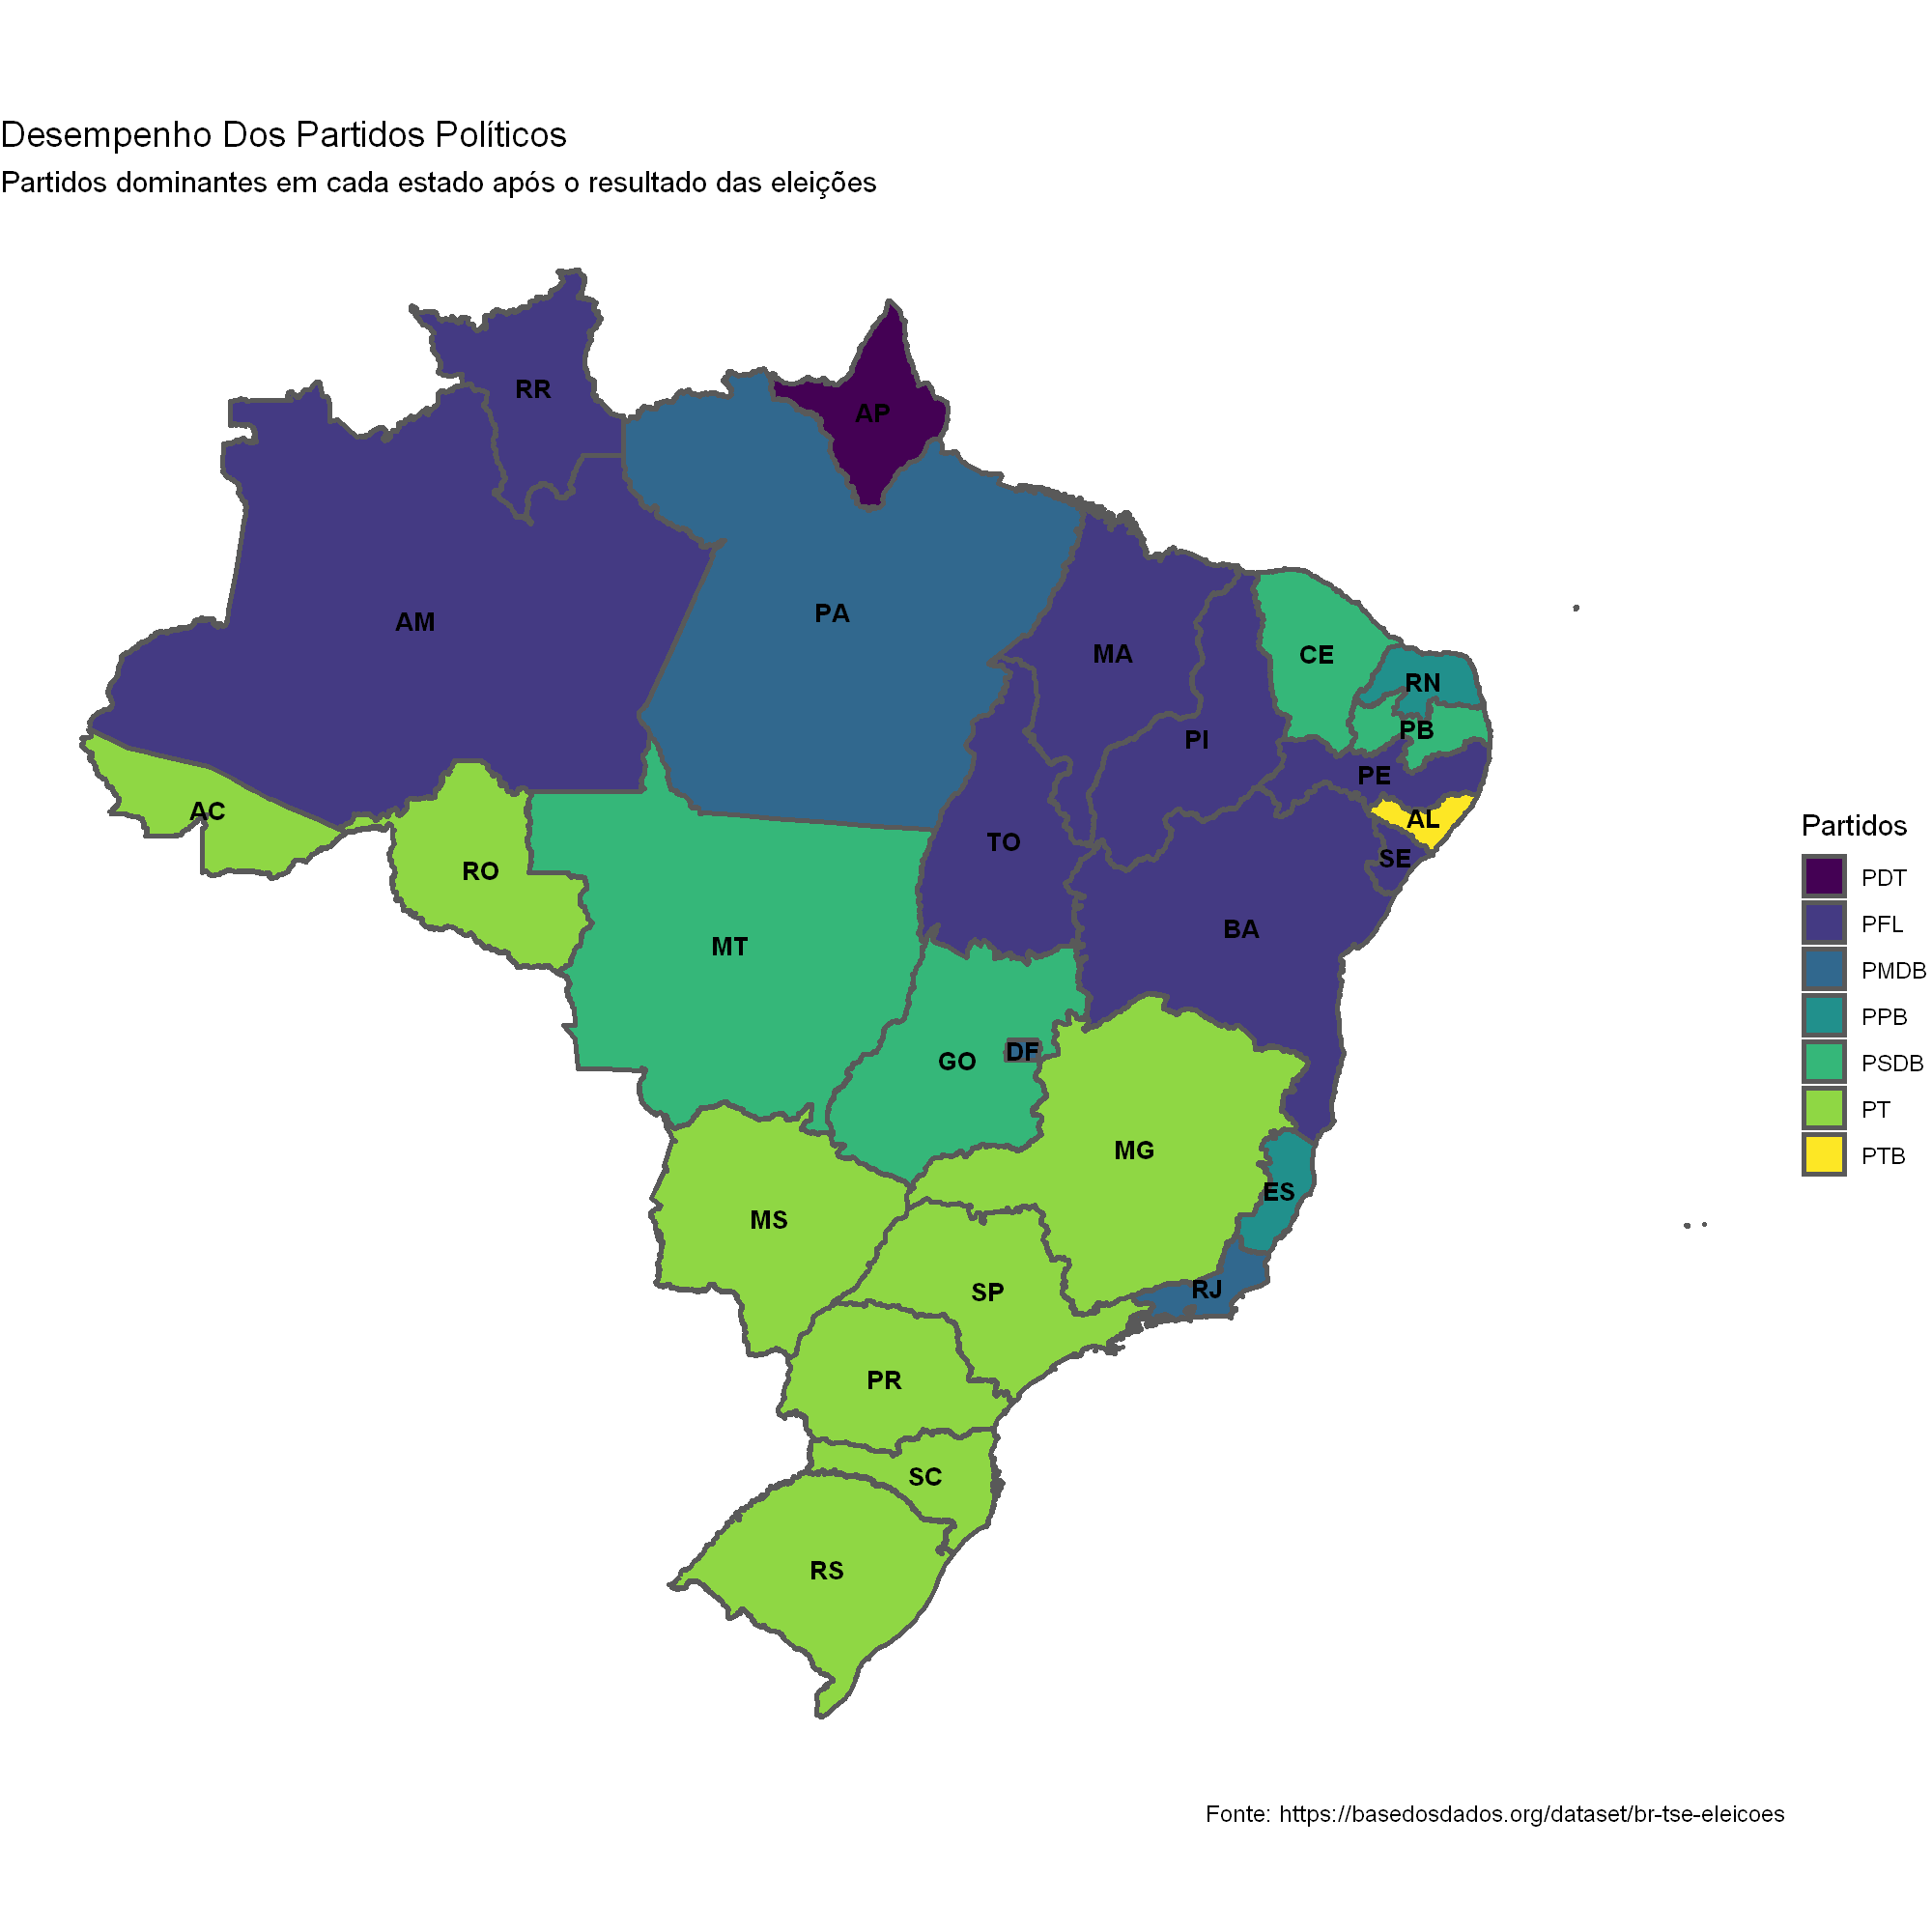

In [29]:
#funcao para gerar os graficos com base no ano
plot_ano <- function(ano) {
                                y <- ano
                                eleicao_res <- df_resultado %>%
                                  filter(!is.na(sigla_uf)) %>%
                              filter(
                                    resultado %in% c("eleito", "eleito por media", "eleito por qp") &
                                      tipo_eleicao == "eleicao ordinaria" &
                                      ano == y
                                  ) %>%
                                  select(ano, sigla_partido, sigla_uf, resultado, cargo) %>%
                                  group_by(sigla_partido, sigla_uf) %>%
                                  mutate(n = n()) %>%
                                  distinct(sigla_partido, sigla_uf, n) %>%
                                  ungroup() %>%
                                  group_by(sigla_uf) %>%
                                  slice(which.max(n))
                                
                                estado <-
                                  estado %>%
                                  rename(sigla_uf = abbrev_state)
                                
                                
                                df_mp <- eleicao_res %>%
                                  left_join(estado, by = "sigla_uf")
                                
                                centroid <- st_centroid(df_mp$geom)
                                
                                lon_lat <-
                                  do.call(rbind, st_geometry(centroid)) %>%
                                  as_tibble() %>%
                                  setNames(c("lon", "lat"))
                                
                                df_mp <- cbind(df_mp, lon_lat)
                                
                                df_mp <- st_as_sf(df_mp)
                                
                                p <-  ggplot(df_mp) +
                                  aes(fill = sigla_partido) +
                                  geom_sf(shape = "circle", size = 0.85) +
                                  geom_text(
                                    data = df_mp,
                                    aes(x = lon, y = lat, label = sigla_uf),
                                    size = 3.3,
                                    col = "black",
                                    fontface = "bold"
                                  ) +
                                  scale_fill_viridis_d(option = "viridis", direction = 1) +
                                  labs(
                                    title = "Desempenho Dos Partidos Políticos",
                                    subtitle = "Partidos dominantes em cada estado após o resultado das eleições",
                                    caption = "Fonte: https://basedosdados.org/dataset/br-tse-eleicoes",
                                    fill = "Partidos"
                                  ) +
                                  theme_void()
                                return(p)
                                
                              }
                              

#exemplo ano=2002, anos precisam ser anos eleitorais entre 2002 e 2018
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)
plot_ano(2002)